In [27]:
import torch
from model_triton import *

#dloss_dx = torch.randn((2, 512, 3072), device="cuda")
#Two shapes are being used: [8, 12, 512, 512], and 4096, 35374
aa = torch.randn((8, 12, 512, 512), device="cuda")
#aa = torch.randn((4096, 35374), device="cuda")
#aa = aa.view(-1)
N = 100

#def t_softmax_fwd(x):
#    return torch.exp(t_log_softmax_fwd(x))
fn_naive = t_log_softmax_fwd
fn_jit = torch.compile(fn_naive)
# burn it
fn_jit(aa) 
#fn_jit(dloss_dx, aa) 

from torch.profiler import profile, record_function, ProfilerActivity, schedule
activities = [ProfilerActivity.CPU, ProfilerActivity.CUDA]
with profile(activities=activities, record_shapes=True) as prof:
    for _ in range(N):
        result = fn_jit(aa)
        #result = fn_jit(dloss_dx, aa)
print(prof.key_averages().table(sort_by="cuda_time_total", row_limit=10))

import time
t0 = time.time()
for _ in range(N):
    result = fn_jit(aa)
    #result = fn_jit(dloss_dx, aa)
torch.cuda.synchronize()
t1 = time.time()
total = t1-t0
print(f'JIT total', total)

import time
t0 = time.time()
for _ in range(N):
    result = fn_naive(aa)
    #result = fn_naive(dloss_dx, aa)
torch.cuda.synchronize()
t1 = time.time()
total = t1-t0
print(f'Naive total', total)

----------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                    Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg     Self CUDA   Self CUDA %    CUDA total  CUDA time avg    # of Calls  
----------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                   Torch-Compiled Region        12.01%       4.866ms        16.90%       6.848ms      68.484us       0.000us         0.00%      41.407ms     414.074us           100  
    triton_per_fused_logsumexp_max_sub_0         2.37%     960.767us         4.89%       1.983ms      19.825us      41.407ms       100.00%      41.407ms     414.074us           100  
                                 triton_         0.00%       0.000us         0.00%  

In [2]:
# import triton
# print(triton.runtime.driver.active.get_current_target())
# device = "cuda" #triton.runtime.driver.active.get_active_torch_device()
# properties = triton.runtime.driver.active.utils.get_device_properties(device)
# See https://github.com/triton-lang/triton/issues/5628, and https://github.com/triton-lang/triton/issues/5388
# properties

In [29]:
def t_log_softmax_fwd(x_logits): # compute log_softmax from logits over the last dimension
    x_logits = x_logits - torch.max(x_logits, axis=-1, keepdims=True)[0] # as it returns (maxs, indices)
    return x_logits - torch.logsumexp(x_logits, axis=-1, keepdims=True)

import triton
import triton.language as tl

# Note that the kernel assumes that n_cols < BLOCK_SIZE
@triton.jit
def t_log_softmax_fwd_k(x_ptr,
                    output_ptr,
                    input_row_stride,
                    output_row_stride,
                    n_rows,
                    n_cols,
                    BLOCK_SIZE: tl.constexpr,
                    num_stages: tl.constexpr,
                    # NOTE: `constexpr` so it can be used as a shape value. <- TODO T: think about it
                    ):
    row_start = tl.program_id(0)
    row_step = tl.num_programs(0)
    for row_idx in tl.range(row_start, n_rows, row_step, num_stages): # TODO T: it fails if I add stages??
        x_row_start_ptr = x_ptr + row_idx * input_row_stride
        offsets = tl.arange(0, BLOCK_SIZE)
        mask = offsets < n_cols
        x = tl.load(x_row_start_ptr + offsets, mask=mask, other=-1e9)
        x_minus_max = x - tl.max(x, axis=0)
        log_denominator = tl.exp(x_minus_max)
        log_denominator = tl.sum(log_denominator, axis=0)
        log_denominator = tl.log(log_denominator)
        output = x_minus_max - log_denominator
        # In case I want to change semantic to t_softmax_fwd_k:
        # nominator = tl.exp(x_minus_max)
        # denominator = tl.sum(nominator, axis=0)
        # output = nominator/denominator    
        output_row_start_ptr = output_ptr + row_idx * output_row_stride
        tl.store(output_row_start_ptr + offsets, output, mask=mask)
    
def t_log_softmax_fwd_t(x: torch.Tensor):
    x_2d = x.reshape((-1, x.shape[-1])) # TODO T: without this reshape, this func is 2times faster
    n_rows, n_cols = x_2d.shape
    BLOCK_SIZE = triton.next_power_of_2(n_cols) 
    output = torch.empty_like(x_2d)
    # TODO T: The below numbers were tuned for A10 by choosing num_wraps=8
    # (add scripting for doing it in the codebase?)
    num_stages = 2
    num_programs = min(n_rows, 720) 
    t_log_softmax_fwd_k[(num_programs,)](x_2d, output, x_2d.stride(0), output.stride(0), n_rows, n_cols, BLOCK_SIZE=BLOCK_SIZE, num_stages=num_stages)
    return output.reshape(x.shape)

fn_t = t_log_softmax_fwd_t

from torch.profiler import profile, record_function, ProfilerActivity, schedule
activities = [ProfilerActivity.CPU, ProfilerActivity.CUDA]
with profile(activities=activities, record_shapes=True) as prof:
    for _ in range(N):
        result = fn_t(aa)
        #result = fn_t(dloss_dx, aa)
print(prof.key_averages().table(sort_by="cuda_time_total", row_limit=20))

import time
t0 = time.time()
for _ in range(N):
    result = fn_t(aa)
    #result = fn_t(dloss_dx, aa)
torch.cuda.synchronize()
t1 = time.time()
total = t1-t0
print(f'total', total)

-------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                     Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg     Self CUDA   Self CUDA %    CUDA total  CUDA time avg    # of Calls  
-------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
      t_log_softmax_fwd_k         0.00%       0.000us         0.00%       0.000us       0.000us      42.138ms       100.00%      42.138ms     421.383us           100  
            aten::reshape         0.75%     293.900us         1.64%     641.021us       3.205us       0.000us         0.00%       0.000us       0.000us           200  
               aten::view         0.89%     347.121us         0.89%     347.121us       1.736us       0.000us         0.00%       0.000us       0.000us        

In [3]:
res1 = fn_jit(aa)
#res1 = fn_jit(dloss_dx, aa)
res2 = fn_t(aa)
#res2 = fn_t(dloss_dx, aa)

assert torch.allclose(res1, res2)
print(f'res1', res1.shape, res1[0])
print(f'res2', res2.shape, res2[0])

res1 torch.Size([8, 12, 512, 512]) tensor([[[-8.6417, -7.5834, -7.2629,  ..., -6.6202, -6.9266, -7.3883],
         [-5.2791, -7.4211, -6.1519,  ..., -6.7668, -6.8302, -7.0569],
         [-6.7590, -7.3116, -7.4388,  ..., -7.3354, -8.0442, -7.4555],
         ...,
         [-6.5508, -6.0505, -6.4529,  ..., -7.8743, -5.9666, -6.9002],
         [-6.9624, -7.2760, -5.4858,  ..., -7.2045, -5.7265, -6.9205],
         [-7.2573, -5.9923, -6.2509,  ..., -8.6741, -6.9800, -5.0438]],

        [[-6.5125, -7.7437, -4.5424,  ..., -6.9761, -7.1864, -8.9105],
         [-5.8850, -7.2715, -6.5765,  ..., -6.9476, -5.6869, -5.9392],
         [-8.2863, -6.5959, -5.6011,  ..., -6.1643, -5.6069, -4.5983],
         ...,
         [-7.5302, -6.7563, -6.3859,  ..., -8.4788, -5.6941, -5.1885],
         [-9.0813, -5.7070, -4.9052,  ..., -7.6157, -7.1952, -7.4642],
         [-6.8408, -6.9974, -7.2518,  ..., -8.6291, -7.3776, -8.1030]],

        [[-8.0489, -7.1273, -6.4578,  ..., -7.7920, -8.3012, -6.2760],
         [

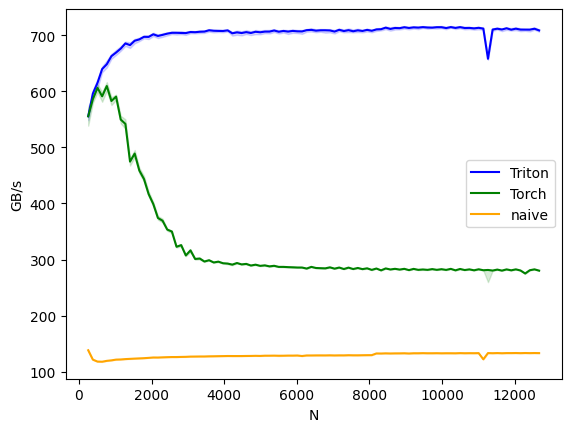

t_log_softmax_fwd:
          N      Triton       Torch       naive
0     256.0  555.389848  555.389848  138.261603
1     384.0  595.781835  585.723942  121.550546
2     512.0  614.880394  606.113302  118.056296
3     640.0  639.583627  590.946807  117.813995
4     768.0  648.158240  609.322328  119.349253
5     896.0  662.617242  582.665524  120.249543
6    1024.0  669.019148  590.414408  121.569328
7    1152.0  676.016100  549.525454  121.830903
8    1280.0  685.284081  541.769093  122.489565
9    1408.0  682.235979  474.533880  122.921903
10   1536.0  690.054411  488.871948  123.348982
11   1664.0  692.469262  458.663820  123.745627
12   1792.0  697.014934  443.524315  124.126814
13   1920.0  696.861988  416.689496  124.687974
14   2048.0  701.545026  398.950933  125.337797
15   2176.0  698.575785  374.072269  125.270266
16   2304.0  700.503588  369.178390  125.637034
17   2432.0  702.699779  353.427510  125.905455
18   2560.0  704.183363  349.929693  126.156120
19   2688.0  704.2073

In [24]:
@triton.testing.perf_report(
    triton.testing.Benchmark(
        x_names=['N'],  # Argument names to use as an x-axis for the plot.
        x_vals=[128 * i for i in range(2, 100)],  # Different possible values for `x_name`.
        #x_log=True,  # x axis is logarithmic.
        line_arg='provider',  # Argument name whose value corresponds to a different line in the plot.
        line_vals=['triton', 'torch', 'naive'],  # Possible values for `line_arg`.
        line_names=['Triton', 'Torch', 'naive'],  # Label name for the lines.
        styles=[('blue', '-'), ('green', '-'), ('orange', '-')],  # Line styles.
        ylabel='GB/s',  # Label name for the y-axis.
        plot_name='t_log_softmax_fwd',  # Name for the plot. Used also as a file name for saving the plot.
        args={'M':4096},  # Values for function arguments not in `x_names` and `y_name`.
        # TODO T: Use real M i.e. 
    ))
def benchmark(M, N, provider):
    #dloss_dx = torch.rand(size, device="cuda", dtype=torch.float32)    
    x = torch.rand(M, N, device="cuda", dtype=torch.float32)
    stream = getattr(torch, "cuda").Stream() # TODO XXX XXX: what is this stream about?
    getattr(torch, "cuda").set_stream(stream)
    quantiles = [0.5, 0.2, 0.8]
    if provider == 'torch':
        ms, min_ms, max_ms = triton.testing.do_bench(lambda: fn_jit(x), quantiles=quantiles)
        #ms, min_ms, max_ms = triton.testing.do_bench(lambda: fn_jit(dloss_dx, x), quantiles=quantiles)
    if provider == 'triton':
        ms, min_ms, max_ms = triton.testing.do_bench(lambda: fn_t(x), quantiles=quantiles)        
        #ms, min_ms, max_ms = triton.testing.do_bench(lambda: fn_t(dloss_dx, x), quantiles=quantiles)
    if provider == 'naive':
        ms, min_ms, max_ms = triton.testing.do_bench(lambda: fn_naive(x), quantiles=quantiles)
        #ms, min_ms, max_ms = triton.testing.do_bench(lambda: fn_naive(dloss_dx, x), quantiles=quantiles)
    gbps = lambda ms: 3 * x.numel() * x.element_size() * 1e-9 / (ms * 1e-3)
    return gbps(ms), gbps(max_ms), gbps(min_ms)
benchmark.run(print_data=True, show_plots=True)

In [5]:
import torch
print(torch.cuda.get_device_properties("cuda"))
from triton.runtime import driver
device = torch.cuda.current_device()
properties = driver.active.utils.get_device_properties(device)
NUM_SM = properties["multiprocessor_count"]
SIZE_SMEM = properties["max_shared_mem"]
NUM_REGS = properties["max_num_regs"]
WARP_SIZE = properties["warpSize"] # Not 64 as A100
properties

_CudaDeviceProperties(name='NVIDIA A10G', major=8, minor=6, total_memory=22723MB, multi_processor_count=80, uuid=df82317b-d317-7368-eed6-8c8a4866f43b, L2_cache_size=6MB)


{'max_shared_mem': 101376,
 'max_num_regs': 65536,
 'multiprocessor_count': 80,
 'warpSize': 32,
 'sm_clock_rate': 1710000,
 'mem_clock_rate': 6251000,
 'mem_bus_width': 384}

In [21]:
num_stages = 4 if SIZE_SMEM > 200000 else 2
num_warps = 8
x_2d = aa.reshape((-1, aa.shape[-1])) # TODO T: without this reshape, this func is 2times faster
n_rows, n_cols = x_2d.shape
BLOCK_SIZE = triton.next_power_of_2(n_cols) 
output = torch.empty_like(x_2d)

kernel = t_log_softmax_fwd_k.warmup(x_2d, output, x_2d.stride(0), output.stride(0), n_rows, n_cols, BLOCK_SIZE=BLOCK_SIZE,
                                   num_stages=num_stages, num_warps=num_warps, grid=(1, ))
kernel._init_handles()
n_regs = kernel.n_regs
size_smem = kernel.metadata.shared
print(f'n_regs', n_regs, 'size_smem', size_smem)

occupancy = NUM_REGS // (n_regs * WARP_SIZE * num_warps)
print(f'occupancy', occupancy, SIZE_SMEM // size_smem)
occupancy = min(occupancy, SIZE_SMEM // size_smem)
num_programs = NUM_SM * occupancy
print(f'num_programs', num_programs)

n_regs 26 size_smem 2080
occupancy 9 48
num_programs 720


In [ ]:
32
2080
4128
6176